In [26]:
# ============================================
# SISTEMA DE DETECCIÓN DE ENLACES SPAM
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
print("Librerias Cargadas")

Librerias Cargadas


In [27]:
# Configuración visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Cargar datos

In [31]:
url = 'https://breathecode.herokuapp.com/asset/internal-link?id=932&path=url_spam.csv'
df = pd.read_csv(url)
print("Dataset Cargado")

Dataset Cargado


In [33]:
print("\n Información general del dataset:")
print(df.info())


 Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB
None


In [34]:
print("\n Primeras filas:")
print(df.head(10))


 Primeras filas:
                                                 url  is_spam
0  https://briefingday.us8.list-manage.com/unsubs...     True
1                             https://www.hvper.com/     True
2                 https://briefingday.com/m/v4n3i4f3     True
3   https://briefingday.com/n/20200618/m#commentform    False
4                        https://briefingday.com/fan     True
5  https://www.brookings.edu/interactives/reopeni...    False
6  https://www.reuters.com/investigates/special-r...    False
7  https://www.theatlantic.com/magazine/archive/2...    False
8  https://www.vox.com/2020/6/17/21294680/john-bo...    False
9  https://www.theguardian.com/travel/2020/jun/18...    False


In [35]:
print("\n Estadísticas descriptivas:")
print(df.describe())


 Estadísticas descriptivas:
                                         url is_spam
count                                   2999    2999
unique                                  2369       2
top     https://www.bloomberg.com/tosv2.html   False
freq                                      26    2303


In [37]:
# Identificar columnas
columna_url = df.columns[0]
columna_spam = df.columns[1]

print(f"\nColumnas identificadas:")
print(f"  - URLs: '{columna_url}'")
print(f"  - Etiquetas: '{columna_spam}'")


Columnas identificadas:
  - URLs: 'url'
  - Etiquetas: 'is_spam'


In [ ]:
# Distribución de clases
print("\n Distribución de clases:")
print(df[columna_spam].value_counts())
print(f"\nPrcentaje de spam: {df[columna_spam].mean()*100:.2f}%")


 Distribución de clases:
is_spam
False    2303
True      696
Name: count, dtype: int64

Porcentaje de spam: 23.21%


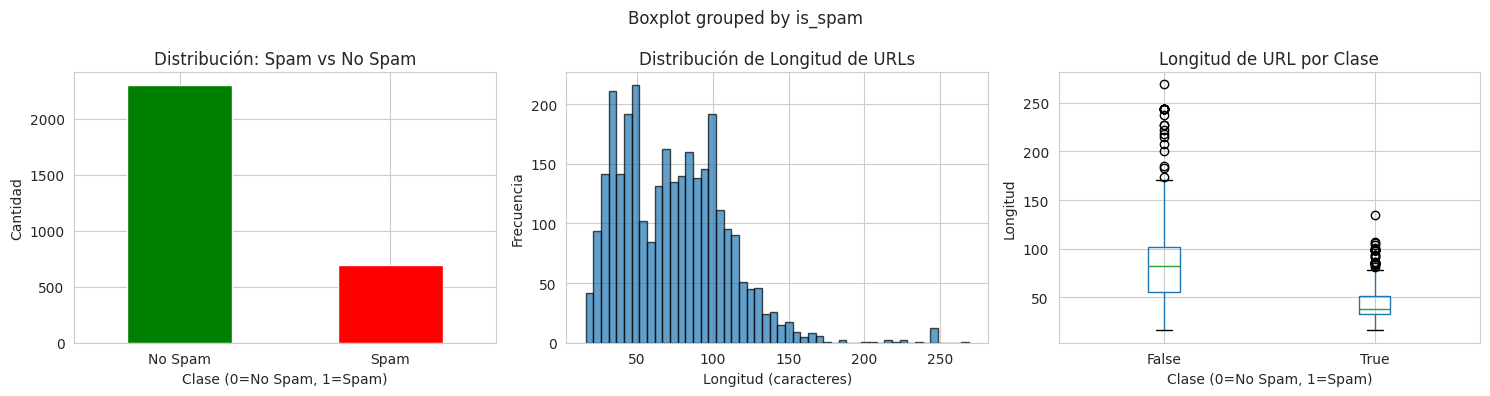

In [40]:
# Visualización 1: Distribución de clases
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Gráfico de barras
df[columna_spam].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Distribución: Spam vs No Spam')
axes[0].set_xlabel('Clase (0=No Spam, 1=Spam)')
axes[0].set_ylabel('Cantidad')
axes[0].set_xticklabels(['No Spam', 'Spam'], rotation=0)

# Análisis de longitud de URLs
df['longitud_url'] = df[columna_url].str.len()
df['longitud_url'].hist(bins=50, ax=axes[1], edgecolor='black', alpha=0.7)
axes[1].set_title('Distribución de Longitud de URLs')
axes[1].set_xlabel('Longitud (caracteres)')
axes[1].set_ylabel('Frecuencia')

# Longitud por clase
df.boxplot(column='longitud_url', by=columna_spam, ax=axes[2])
axes[2].set_title('Longitud de URL por Clase')
axes[2].set_xlabel('Clase (0=No Spam, 1=Spam)')
axes[2].set_ylabel('Longitud')

plt.tight_layout()
plt.show()

In [42]:
print("\n Estadísticas de longitud por clase:")
print(df.groupby(columna_spam)['longitud_url'].describe())


 Estadísticas de longitud por clase:
          count       mean        std   min   25%   50%    75%    max
is_spam                                                              
False    2303.0  82.128528  34.136308  16.0  56.0  82.0  102.0  269.0
True      696.0  44.816092  20.152029  16.0  33.0  38.0   51.0  135.0


In [44]:
# Análisis de caracteres especiales
df['num_puntos'] = df[columna_url].str.count(r'\.')
df['num_guiones'] = df[columna_url].str.count(r'-')
df['num_barras'] = df[columna_url].str.count(r'/')
df['num_digitos'] = df[columna_url].str.count(r'\d')

print("\n Características promedio por clase:")
features_eda = ['longitud_url', 'num_puntos', 'num_guiones', 'num_barras', 'num_digitos']
print(df.groupby(columna_spam)[features_eda].mean())


 Características promedio por clase:
         longitud_url  num_puntos  num_guiones  num_barras  num_digitos
is_spam                                                                
False       82.128528    1.971776     5.431177    5.417282     7.228832
True        44.816092    1.916667     0.949713    3.869253     1.431034


PREPROCESAMIENTO

In [46]:
def limpiar_url(url):
    """
    Limpia y tokeniza una URL para el modelo
    """
    if pd.isna(url):
        return ''
    
    # Convertir a minúsculas
    url = str(url).lower()
    # Quitar protocolo y www
    url = url.replace('http://', '').replace('https://', '').replace('www.', '')
    
    # Separar por caracteres especiales (convertirlos en espacios)
    url = re.sub(r'[/\-_\.?=&@:+%#\(\)\[\]]', ' ', url)
    
    # Quitar espacios múltiples
    url = ' '.join(url.split())
    
    return url

Aplicar limpieza

In [49]:
df['url_limpia'] = df[columna_url].apply(limpiar_url)

print("\n Ejemplos de URLs preprocesadas:")
for i in range(5):
    print(f"\nOriginal: {df[columna_url].iloc[i]}")
    print(f"Limpia:   {df['url_limpia'].iloc[i]}")
    print(f"Spam     {df[columna_spam].iloc[i]}")


 Ejemplos de URLs preprocesadas:

Original: https://briefingday.us8.list-manage.com/unsubscribe
Limpia:   briefingday us8 list manage com unsubscribe
Spam     True

Original: https://www.hvper.com/
Limpia:   hvper com
Spam     True

Original: https://briefingday.com/m/v4n3i4f3
Limpia:   briefingday com m v4n3i4f3
Spam     True

Original: https://briefingday.com/n/20200618/m#commentform
Limpia:   briefingday com n 20200618 m commentform
Spam     False

Original: https://briefingday.com/fan
Limpia:   briefingday com fan
Spam     True


In [51]:
# Preparar X e y
X = df['url_limpia']
y = df[columna_spam]

# División train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nDivisión de datos:")
print(f"  Train: {len(X_train)} URLs ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test:  {len(X_test)} URLs ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n  Distribución en Train:")
print(f"    No Spam: {(y_train==0).sum()}")
print(f"    Spam:    {(y_train==1).sum()}")


División de datos:
  Train: 2399 URLs (80.0%)
  Test:  600 URLs (20.0%)

  Distribución en Train:
    No Spam: 1842
    Spam:    557


Vectorización con TF-IDF

In [53]:
vectorizer = TfidfVectorizer(
    max_features=1500,   # Top 1500 términos más importantes
    ngram_range=(1, 2),  # Unigramas y bigramas
    min_df=2,            # Ignorar términos que aparecen en menos de 2 documentos
    max_df=0.95          # Ignorar términos muy frecuentes
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"\n Vectorización completada:")
print(f"  Train shape: {X_train_vec.shape}")
print(f"  Test shape:  {X_test_vec.shape}")


 Vectorización completada:
  Train shape: (2399, 1500)
  Test shape:  (600, 1500)


SVM CON PARÁMETROS POR DEFECTO

In [54]:
# Entrenar SVM 
svm_base = SVC(kernel='linear', random_state=42)
print("\n⏳ Entrenando SVM...")
svm_base.fit(X_train_vec, y_train)


⏳ Entrenando SVM...


,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [55]:
# Predicciones
y_pred_train = svm_base.predict(X_train_vec)
y_pred_test = svm_base.predict(X_test_vec)

In [56]:
# Métricas
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)


In [59]:
print(f"\nResultados SVM base:")
print(f"  Accuracy Train: {acc_train:.4f}")
print(f"  Accuracy Test:  {acc_test:.4f}")


Resultados SVM base:
  Accuracy Train: 0.9662
  Accuracy Test:  0.9300


In [60]:
print("\n Reporte de clasificación (Test):")
print(classification_report(y_test, y_pred_test, target_names=['No Spam', 'Spam']))


 Reporte de clasificación (Test):
              precision    recall  f1-score   support

     No Spam       0.94      0.97      0.96       461
        Spam       0.89      0.79      0.84       139

    accuracy                           0.93       600
   macro avg       0.92      0.88      0.90       600
weighted avg       0.93      0.93      0.93       600



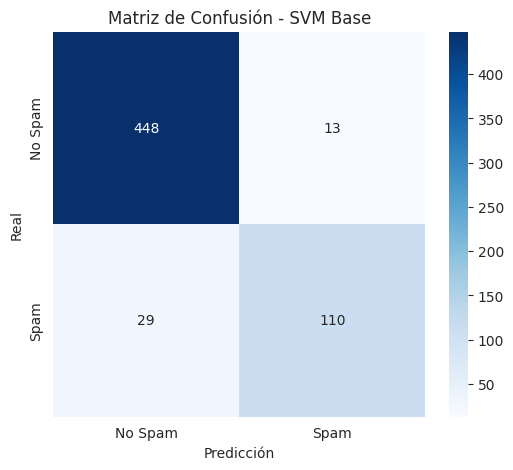

In [61]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Spam', 'Spam'],
            yticklabels=['No Spam', 'Spam'])
plt.title('Matriz de Confusión - SVM Base')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()


Analisis de Resultados:
1. Verdaderos Negativos (448): URLs que realmente no eran spam y tu modelo también las clasificó como “No Spam”. 
2. Verdaderos Positivos (110): URLs correctamente identificadas como spam.
3. Falsos Positivos (13): URLs legítimas que fueron clasificadas como spam por error.
4. Falsos Negativos (29): URLs spam que el modelo no detectó.

OPTIMIZACIÓN CON GRID SEARCH

In [63]:
# Definir grid de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],           # Regularización
    'kernel': ['linear', 'rbf'],       # Tipo de kernel
    'gamma': ['scale', 'auto', 0.1, 1] # Para kernel rbf
}

print("\n Buscando mejores hiperparámetros...")
print(f"Grid de búsqueda: {param_grid}")


 Buscando mejores hiperparámetros...
Grid de búsqueda: {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto', 0.1, 1]}


In [ ]:
# Grid Search con validación cruzada
grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,                    # 5-fold cross validation
    scoring='accuracy',
    n_jobs=-1,              # Usar todos los cores
    verbose=1
)

grid_search.fit(X_train_vec, y_train)

print(f"\nMejores parámetros encontrados:")
print(grid_search.best_params_)
print(f"\nMejor score en validación cruzada: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits



✅ Resultados SVM base:
  Accuracy Train: 0.9662
  Accuracy Test:  0.9300

📊 Reporte de clasificación (Test):
              precision    recall  f1-score   support

     No Spam       0.94      0.97      0.96       461
        Spam       0.89      0.79      0.84       139

    accuracy                           0.93       600
   macro avg       0.92      0.88      0.90       600
weighted avg       0.93      0.93      0.93       600



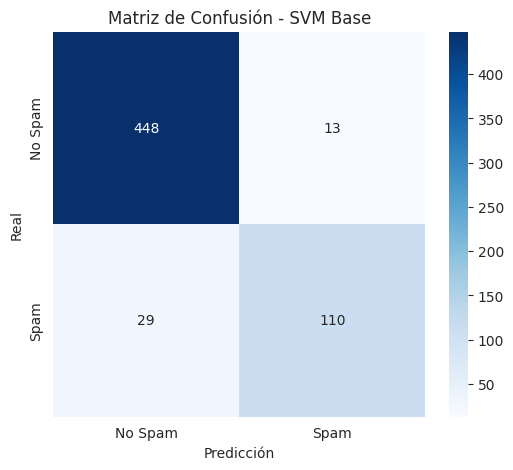


PASO 4: OPTIMIZACIÓN DE HIPERPARÁMETROS

🔍 Buscando mejores hiperparámetros...
Grid de búsqueda: {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto', 0.1, 1]}
Fitting 5 folds for each of 32 candidates, totalling 160 fits

✅ Mejores parámetros encontrados:
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

Mejor score en validación cruzada: 0.9554

🎯 Resultados SVM optimizado:
  Accuracy Train: 0.9862
  Accuracy Test:  0.9500

📊 Reporte de clasificación (Test - Optimizado):
              precision    recall  f1-score   support

     No Spam       0.96      0.97      0.97       461
        Spam       0.90      0.88      0.89       139

    accuracy                           0.95       600
   macro avg       0.93      0.92      0.93       600
weighted avg       0.95      0.95      0.95       600



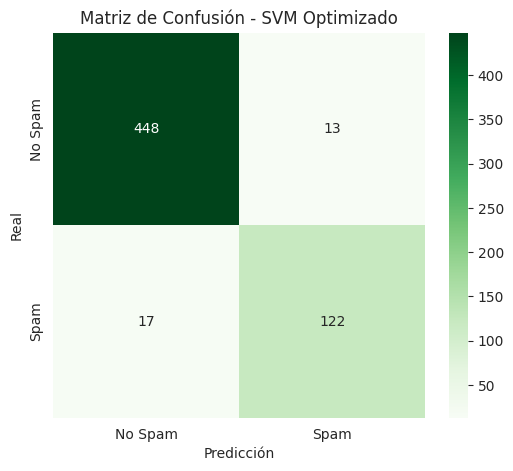


📈 COMPARACIÓN DE MODELOS:
Modelo               Acc Train    Acc Test    
--------------------------------------------
SVM Base             0.9662       0.9300
SVM Optimizado       0.9862       0.9500

PASO 5: GUARDAR MODELO Y VECTORIZADOR
✅ Vectorizador guardado: vectorizer.pkl
✅ Modelo guardado: svm_spam_detector.pkl

BONUS: FUNCIÓN DE PREDICCIÓN

🧪 Pruebas con URLs de ejemplo:

URL: https://www.google.com
Predicción: 🚨 SPAM (score: 0.352)

URL: http://free-prize-winner-click-here-now.com/claim?id=12345
Predicción: ✅ NO SPAM (score: -0.708)

URL: https://github.com/usuario/proyecto
Predicción: ✅ NO SPAM (score: -1.000)

URL: http://secure-bank-verify-account-urgent.net/login
Predicción: ✅ NO SPAM (score: -0.526)

✅ PROCESO COMPLETADO


In [ ]:


# Mejor modelo
svm_optimizado = grid_search.best_estimator_

# Evaluar modelo optimizado
y_pred_train_opt = svm_optimizado.predict(X_train_vec)
y_pred_test_opt = svm_optimizado.predict(X_test_vec)

acc_train_opt = accuracy_score(y_train, y_pred_train_opt)
acc_test_opt = accuracy_score(y_test, y_pred_test_opt)

print(f"\n🎯 Resultados SVM optimizado:")
print(f"  Accuracy Train: {acc_train_opt:.4f}")
print(f"  Accuracy Test:  {acc_test_opt:.4f}")

print("\n📊 Reporte de clasificación (Test - Optimizado):")
print(classification_report(y_test, y_pred_test_opt, target_names=['No Spam', 'Spam']))

# Matriz de confusión optimizada
cm_opt = confusion_matrix(y_test, y_pred_test_opt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Spam', 'Spam'],
            yticklabels=['No Spam', 'Spam'])
plt.title('Matriz de Confusión - SVM Optimizado')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

# Comparación
print("\n📈 COMPARACIÓN DE MODELOS:")
print(f"{'Modelo':<20} {'Acc Train':<12} {'Acc Test':<12}")
print("-" * 44)
print(f"{'SVM Base':<20} {acc_train:.4f}       {acc_test:.4f}")
print(f"{'SVM Optimizado':<20} {acc_train_opt:.4f}       {acc_test_opt:.4f}")

# ============================================
# PASO 5: GUARDAR EL MODELO
# ============================================

print("\n" + "="*60)
print("PASO 5: GUARDAR MODELO Y VECTORIZADOR")
print("="*60)

# Guardar vectorizador
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
print("✅ Vectorizador guardado: vectorizer.pkl")

# Guardar modelo optimizado
with open('svm_spam_detector.pkl', 'wb') as f:
    pickle.dump(svm_optimizado, f)
print("✅ Modelo guardado: svm_spam_detector.pkl")

# ============================================
# BONUS: FUNCIÓN PARA PREDECIR NUEVAS URLs
# ============================================

print("\n" + "="*60)
print("BONUS: FUNCIÓN DE PREDICCIÓN")
print("="*60)

def predecir_spam(url_nueva):
    """
    Predice si una URL es spam o no
    """
    url_limpia = limpiar_url(url_nueva)
    url_vec = vectorizer.transform([url_limpia])
    prediccion = svm_optimizado.predict(url_vec)[0]
    probabilidad = svm_optimizado.decision_function(url_vec)[0]
    
    resultado = "🚨 SPAM" if prediccion == 1 else "✅ NO SPAM"
    return resultado, probabilidad

# Probar con ejemplos
print("\n🧪 Pruebas con URLs de ejemplo:")
urls_prueba = [
    "https://www.google.com",
    "http://free-prize-winner-click-here-now.com/claim?id=12345",
    "https://github.com/usuario/proyecto",
    "http://secure-bank-verify-account-urgent.net/login"
]

for url in urls_prueba:
    resultado, score = predecir_spam(url)
    print(f"\nURL: {url}")
    print(f"Predicción: {resultado} (score: {score:.3f})")

print("\n" + "="*60)
print("✅ PROCESO COMPLETADO")
print("="*60)